# <u>Animated Landsat time series</u> <img align="right" src="../resources/csiro_easi_logo.png">

**Contents**
  - [Overview](#Overview)
  - [Notebook setup](#Notebook-setup)
    - [Importing modules and functions](#Importing-modules-and-functions)
    - [Setting up the analysis variables](#Setting-up-the-analysis-variables)
  - [Loading up the Landsat-8 time series](#Loading-up-the-Landsat-8-time-series)
    - [DataCube query](#DataCube-query)
      - [Satellite product](#Satellite-product)
      - [Spatial extents](#Spatial-extents)
      - [Data query and load](#Data-query-and-load)
  - [Processing the time series](#Processing-the-time-series)
    - [Percentage of clear pixels](#Percentage-of-clear-pixels)
    - [Storing the result](#Storing-the-result)
    - [Memory management](#Memory-management)
  - [Displaying results](#Displaying-results)
    - [Static plots](#Static-plots)
    - [Animated output](#Animated-output)

# Overview

This notebook demonstrates how to create a time series of (mostly) cloud-free observations from Landsat 8, with the data displayed as an animation where each frame is annotated with its date.

This notebook is adapted from an earlier [Digital Earth Australia](https://github.com/GeoscienceAustralia/dea-notebooks) example by Robbi Bishop-Taylor, and a [related notebook](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Frequently_used_code/Animated_timeseries.ipynb) can also be found in the current DEA notebook series.

# Notebook setup

In this section, we import the relevant Python modules and functions needed in the rest of this notebook. We also define some input variables for the subsequent analysis.

## Importing modules and functions

In [1]:
### System
import os, sys

### Datacube 
import datacube
from datacube import Datacube
from datacube.utils import masking
from datacube.utils import geometry
from datacube.utils.geometry import CRS

### Data tools
import numpy as np
import xarray as xr
import pandas as pd
pd.set_option('display.max_rows', None)

### Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

# EASI tools
import git
import sys, os
os.environ['USE_PYGEOS'] = '0'
repo = git.Repo('.', search_parent_directories=True)
if repo.working_tree_dir not in sys.path: sys.path.append(repo.working_tree_dir + '/scripts')

repo = '/home/jovyan/cal-notebooks/scripts'
if repo not in sys.path: sys.path.append(repo)

from easi_tools import EasiDefaults
import notebook_utils
easi = EasiDefaults(deployment="asia")
#from easi_tools.notebook_utils import mostcommon_crs, initialize_dask, localcluster_dashboard, heading


from app_utils import animated_timeseries

# Dask
from dask.distributed import Client, LocalCluster

Successfully found configuration for deployment "asia"


### Local dask cluster

For local cluster options, see https://docs.dask.org/en/latest/setup/single-distributed.html

The Dask Dashboard link shown after the following cell is a helpful resource to explore the activity and state of your dask cluster.

In [2]:
# Dask gateway (separate worker machines)
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
display(client)

# Access AWS "requester-pays" buckets
# This is necessary for reading data from most third-party AWS S3 buckets such as for Landsat and Sentinel-2
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

Starting new cluster.


<Client: 'tls://10.0.61.99:8786' processes=0 threads=0, memory=0 B>

## Setting up the analysis variables

In the next cell, we set up the (user-defined) input variables for the current analysis: geographical extent, time period of interest, output resolution, and minimum proportion of cloud-free pixels used to filter the observations.

In [3]:
### Centre point of area to analyse, with a surrounding buffer (in metres) around it
lat, lon, buffer_m = 25.05, 91.10, 8000   # Haor area

### Time window for which to return the Landsat data
time_range = ('2014-01-01', '2020-01-01')

### Output resolution (in meters)
resolution = (-30, 30)

### Minimum proportion of cloud-free pixels required to retain time slices
# E.g. a proportion of 0.95 means that only observations with less than 5% cloud will be returned.
landsat_cloud_free_prop = 0.85

### Output animation file
gif_out_file = './outputs/animated_Landsat_time_series.gif'   # results saved to the current directory

# Loading up the Landsat-8 time series

## DataCube query

Before loading up the data we're interested in, let's connect to the DataCube database:

In [4]:
dc = datacube.Datacube(app='Time series animation')

Next, in order to load data from the DataCube database, we will create a `query` (Python dictionary) containing the relevant analysis parameters. 

### Satellite product

The Landsat-8 product we will use here is called `landsat8_c2l2_sr`. To review the available data coverage, please visit https://explorer.eail.easi-eo.solutions/products/landsat8_c2l2_sr

In [5]:
product = 'landsat8_c2l2_sr'

We can investigate this product (without loading up any data at this stage) by listing its specific measurements:

In [6]:
dc.list_measurements().loc[product]

name   dtype        units  nodata  \
measurement                                            
coastal         coastal  uint16  reflectance       0   
blue               blue  uint16  reflectance       0   
green             green  uint16  reflectance       0   
red                 red  uint16  reflectance       0   
nir08             nir08  uint16  reflectance       0   
swir16           swir16  uint16  reflectance       0   
swir22           swir22  uint16  reflectance       0   
qa_pixel       qa_pixel  uint16    bit_index       1   
qa_aerosol   qa_aerosol   uint8    bit_index       1   
qa_radsat     qa_radsat  uint16    bit_index       1   

                                              flags_definition  \
measurement                                                      
coastal                                                    NaN   
blue                                                       NaN   
green                                                      NaN   
red                                                        NaN   
nir08                                                      NaN   
swir16                                                     NaN   
swir22                                                     NaN   
qa_pixel     {'snow': {'bits': 5, 'values': {'0': 'not_high...   
qa_aerosol   {'water': {'bits': 2, 'values': {'0': 'not_wat...   
qa_radsat    {'qa_radsat': {'bits': [0, 1, 2, 3, 4, 5, 6, 7...   

                                                    aliases  add_offset  \
measurement                                                               
coastal                [SR_B1, band_1, B1, coastal_aerosol]         NaN   
blue                                    [SR_B2, band_2, B2]         NaN   
green                                   [SR_B3, band_3, B3]         NaN   
red                                     [SR_B4, band_4, B4]         NaN   
nir08                              [SR_B5, band_5, B5, nir]         NaN   
swir16                           [SR_B6, band_6, B6, swir1]         NaN   
swir22                           [SR_B7, band_7, B7, swir2]         NaN   
qa_pixel     [pixel_quality, level2_qa, QA_PIXEL, pixel_qa]         NaN   
qa_aerosol          [sr_aerosol, SR_QA_AEROSOL, aerosol_qa]         NaN   
qa_radsat             [saturation_qa, QA_RADSAT, radsat_qa]         NaN   

             scale_factor  
measurement                
coastal               NaN  
blue                  NaN  
green                 NaN  
red                   NaN  
nir08                 NaN  
swir16                NaN  
swir22                NaN  
qa_pixel              NaN  
qa_aerosol            NaN  
qa_radsat             NaN

From this, we can work out the specific bands of interest (e.g. `red`, `green`, `blue`) as well as the name of the pixel quality band (`qa_pixel`):

In [7]:
selected_bands = ['red', 'green', 'blue', 'qa_pixel']

### Spatial extents

When loading up the dataset, we can essentially request the data in any specific projection. Here, we will be using the dataset's native projection:

If you set your own coordinates above, you might need to change the output CRS. There are various tools online to determine which UTM zone to set it manually or you can calculate it in python as shown below.

In [8]:
# product_crs = 'EPSG:32646'   # WGS 84 / UTM zone 46N

product_crs = f'epsg:{int(32700-np.round((45+lat)/90,0)*100+np.round((183+lon)/6,0))}'
print(product_crs)

epsg:32646


And we can now convert the centre point of our analysis window to that projection:

In [9]:
### Define lon/lat centre point as Geometry object
lon_lat_point = geometry.point(lon, lat, CRS('WGS84'))

### Re-project centre point from lat/long to the selected projection
x, y = lon_lat_point.to_crs(product_crs).points[0]
x, y

(308326.52186230285, 2771830.146713409)

We can then use these projected coordinates as input to our query. But most importantly, we can also apply our buffer `buffer_m` around the re-projected centre point (`x`, `y`). Earlier, we defined the buffer value in metres &ndash; this requires the centre point to be in projected coordinates.

### Data query and load

We create the DataCube query by selecting a square window around the point of interest. We also select the time window of interest, as well as the desired satellite bands.

In [10]:
query = { 'x': (x-buffer_m, x+buffer_m),
          'y': (y-buffer_m, y+buffer_m),    
          'time': time_range,
          'measurements' : selected_bands,
          'crs': product_crs,          # CRS of 'x','y' query parameters
          'output_crs': product_crs,   # CRS of output data
          'resolution': resolution,
          #'dask_chunks': {'time': 1}
        'dask_chunks':{'time':10,'x':200,'y':200}

        }

In [11]:
### Load data
data = dc.load(product=product, group_by='solar_day', skip_broken_datasets = True,**query)
data

<xarray.Dataset>
Dimensions:      (time: 129, y: 535, x: 535)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T04:25:18.259892 ... 2019-12...
  * y            (y) float64 2.78e+06 2.78e+06 2.78e+06 ... 2.764e+06 2.764e+06
  * x            (x) float64 3.003e+05 3.003e+05 ... 3.163e+05 3.163e+05
    spatial_ref  int32 32646
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    qa_pixel     (time, y, x) uint16 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
Attributes:
    crs:           epsg:32646
    grid_mapping:  spatial_ref

As we can see, the `data` object is an `Xarray` dataset with 17 time slices, and around 530 pixels in both the `x` and `y` dimensions. We can work out the size of this variable in memory, as follows:

In [12]:
print(f"The size of 'data' in memory is {data.nbytes/(1024**2):.2f} MB.")

The size of 'data' in memory is 281.71 MB.


# Processing the time series

In each time slice, we will calculate the proportion of clear pixels by summing the pixels that are not flagged as being problematic in the Landsat PQ layer. Here, only cloudy pixels, cloud-shadowed pixels, or pixels without valid data in every band are included in set of "problematic" pixels.

## Percentage of clear pixels

The "cloud mask" for this dataset is constructed using the pixel quality (PQ) data layer `qa_pixel` and a few quality flags to remove clouds and cloud shadows. We can can simply count the number of cloud free observations in each image, and divide it by the total number of pixels to give us a cloud-free percentage.

To do this, we use the `xarray` function `xarray.sum()`, which sums up all the array values along the specified dimension(s). The array we'll apply this function to is filled with boolean values (`True` or `False`, essentially seen as 1 or 0 from the perspective of the `sum` function), and we will sum over both the `x` and `y` dimensions. This will thus give us the total number of cloud free pixels in each time slice.

In [13]:
good_pixel_flags = {
    'nodata': False,
    'cloud': 'not_high_confidence', # 'not_high_confidence' means that it is unlikely that there is cloud. 'high_confidence' for cloud means that it is probably a cloudy pixel
    'cloud_shadow': 'not_high_confidence' # 'not_high_confidence' means that it is unlikely that there is cloud shadow. 'high_confidence' for cloud shadow means that the pixel probably has cloud shadow
}
### Mask of clear pixels (for each time slices): True/1.0 if clear, False/0.0 if cloud-affected
clear_mask = masking.make_mask(data.qa_pixel, **good_pixel_flags) 

### Cloud-free percentages
_, x_len, y_len = clear_mask.shape
cloud_free_percentage = clear_mask.sum(dim=['x','y']) / (x_len*y_len) * 100
display(cloud_free_percentage)

<xarray.DataArray 'qa_pixel' (time: 129)>
dask.array<mul, shape=(129,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T04:25:18.259892 ... 2019-12...
    spatial_ref  int32 32646

The resulting object `cloud_free_percentage` is an array of percentages, one per time step. We can use the built-in `plot` function to display this time series as a graph:

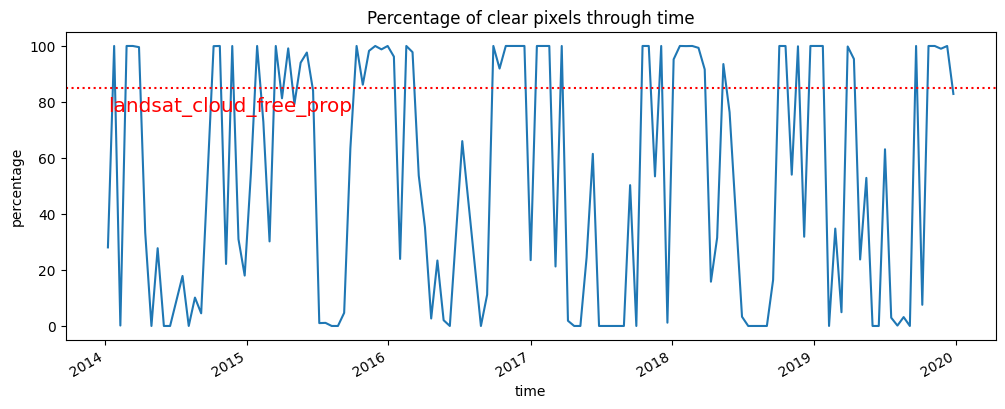

In [14]:
cloud_free_percentage.plot(aspect=3, size=4)
plt.axhline(y=landsat_cloud_free_prop*100, color='r', linestyle=':')
plt.text( x=cloud_free_percentage.time.values[0], y=landsat_cloud_free_prop*0.9*100, 
          s='landsat_cloud_free_prop', size='x-large', c='red')

plt.xlabel('time')
plt.ylabel(r'percentage')
plt.title("Percentage of clear pixels through time");

## Storing the result

The most useful place for the cloud percentage time series is with our original dataset (`data`). It corresponds to a single value per time slice, so let's add it back to `data` as a data variable, and give it a `time` coordinate. The timestamps are the same as the original observations, so we can construct the new data variable as a `DataArray` with the calculated percentage values, and a `time` coordinate copied from the original `data` Dataset.

In [15]:
data['cloud_free_percentage'] = xr.DataArray(cloud_free_percentage, coords=[('time', data.time.data)])
data

<xarray.Dataset>
Dimensions:                (time: 129, y: 535, x: 535)
Coordinates:
  * time                   (time) datetime64[ns] 2014-01-09T04:25:18.259892 ....
  * y                      (y) float64 2.78e+06 2.78e+06 ... 2.764e+06 2.764e+06
  * x                      (x) float64 3.003e+05 3.003e+05 ... 3.163e+05
    spatial_ref            int32 32646
Data variables:
    red                    (time, y, x) uint16 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    green                  (time, y, x) uint16 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    blue                   (time, y, x) uint16 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    qa_pixel               (time, y, x) uint16 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    cloud_free_percentage  (time) float64 dask.array<chunksize=(10,), meta=np.ndarray>
Attributes:
    crs:           epsg:32646
    grid_mapping:  spatial_ref

At this point, we have a single `Xarray Dataset` containing all our Landsat measurements (bands) and the newly computed `cloud_free_percentage` variable, for every time slice.

Now, we only want to retain the timeslices that meet our cloud-free percentage threshold. We can simply use `Xarray` indexing to do this, as follows:

In [16]:
### Indices of time slices with (mostly) clear pixels
selected_time_indices = ( data.cloud_free_percentage>=landsat_cloud_free_prop )

### Select time slices from the data
filtered_data = data.sel(time=selected_time_indices)
filtered_data

<xarray.Dataset>
Dimensions:                (time: 105, y: 535, x: 535)
Coordinates:
  * time                   (time) datetime64[ns] 2014-01-09T04:25:18.259892 ....
  * y                      (y) float64 2.78e+06 2.78e+06 ... 2.764e+06 2.764e+06
  * x                      (x) float64 3.003e+05 3.003e+05 ... 3.163e+05
    spatial_ref            int32 32646
Data variables:
    red                    (time, y, x) uint16 dask.array<chunksize=(7, 200, 200), meta=np.ndarray>
    green                  (time, y, x) uint16 dask.array<chunksize=(7, 200, 200), meta=np.ndarray>
    blue                   (time, y, x) uint16 dask.array<chunksize=(7, 200, 200), meta=np.ndarray>
    qa_pixel               (time, y, x) uint16 dask.array<chunksize=(7, 200, 200), meta=np.ndarray>
    cloud_free_percentage  (time) float64 dask.array<chunksize=(7,), meta=np.ndarray>
Attributes:
    crs:           epsg:32646
    grid_mapping:  spatial_ref

Following the removal of time slices significantly affected by cloud and other issues, we now have a dataset with only 19 time slices (compared to the 68 time steps in the original dataset).

## Memory management

At this point we have several variables that we no longer need in our dataset, chewing up (some) memory. From this point on, we only need the "filtered" dataset, so let's set other variables to `None`, which will free up memory.

# Displaying results

## Static plots

We can plot the result as a series of images, one per time step. For plotting reasons, we need to set all the invalid data to `NaN` first:

In [17]:
### Set 'nodata' pixels to 'NaN' for all data variables
filtered_data = masking.mask_invalid_data( filtered_data[['red', 'green', 'blue']] )

Now that we have the data we want and the data is relatively small, we can choose to use `.compute()` to bring the results back from the local Dask cluster to local memory, which will make visualisation quicker.

Note that the data below no longer shows each Data variable as a `dask.array`

In [18]:
filtered_data = filtered_data.compute()
filtered_data

<xarray.Dataset>
Dimensions:      (time: 105, y: 535, x: 535)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T04:25:18.259892 ... 2019-12...
  * y            (y) float64 2.78e+06 2.78e+06 2.78e+06 ... 2.764e+06 2.764e+06
  * x            (x) float64 3.003e+05 3.003e+05 ... 3.163e+05 3.163e+05
    spatial_ref  int32 32646
Data variables:
    red          (time, y, x) float32 1.19e+04 1.175e+04 ... 1.083e+04 1.114e+04
    green        (time, y, x) float32 1.197e+04 1.179e+04 ... 1.133e+04
    blue         (time, y, x) float32 1.109e+04 1.12e+04 ... 9.678e+03 9.724e+03
Attributes:
    crs:           epsg:32646
    grid_mapping:  spatial_ref

Let's select a few time indices from the time series, and plot the corresponding maps as RGB images:

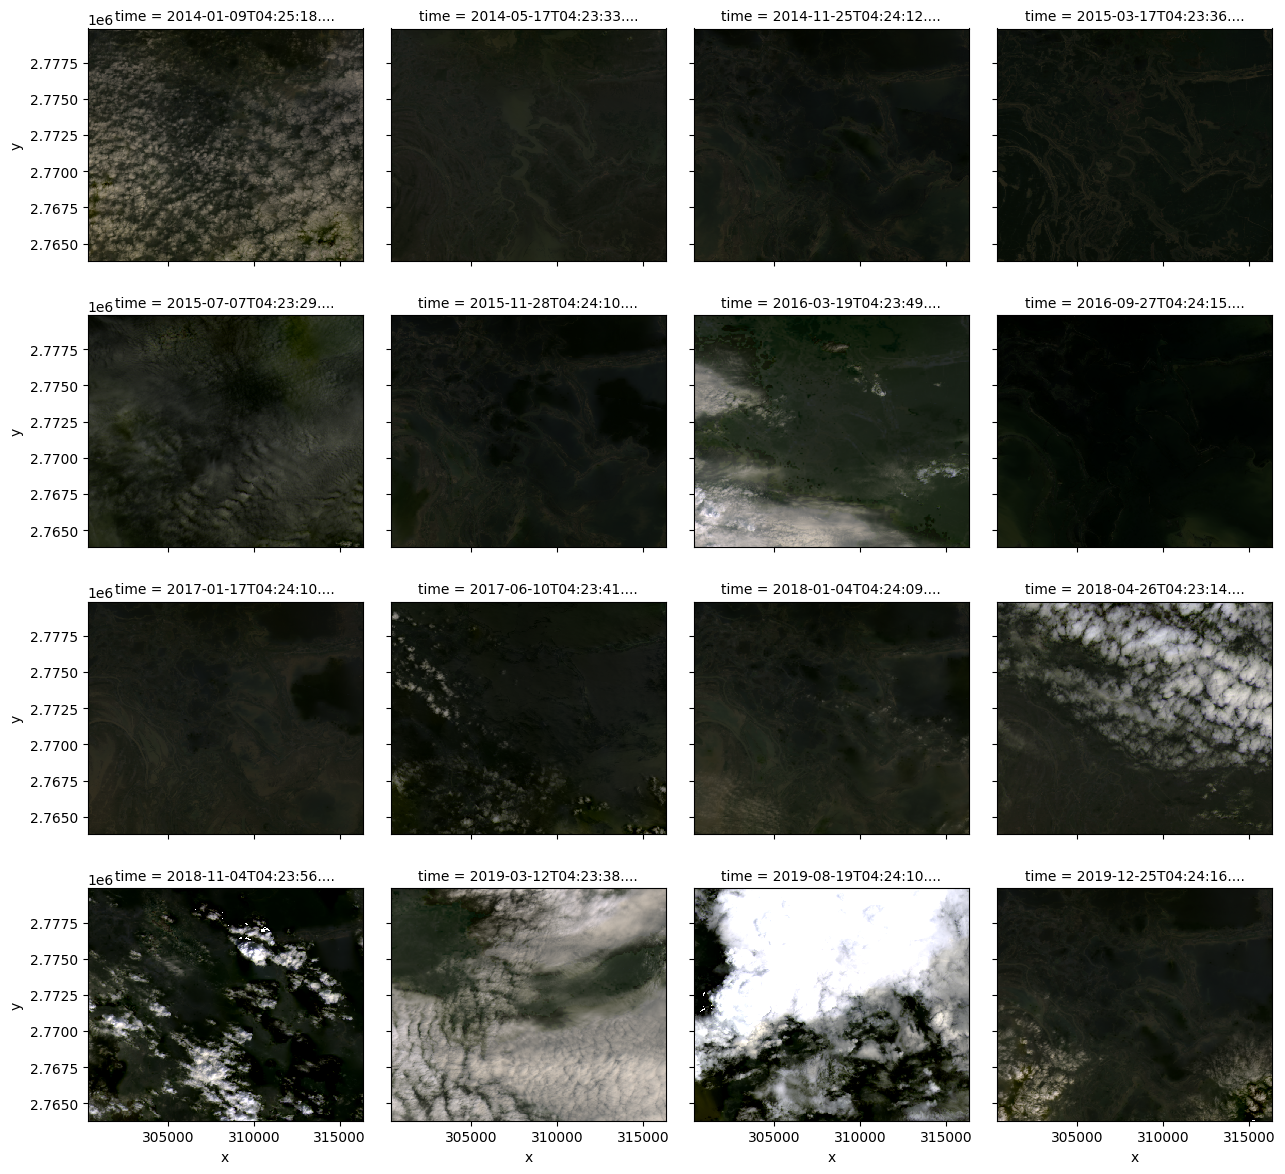

In [19]:
num_time = filtered_data.sizes['time']
time_ind = np.linspace(1, num_time, 16, dtype='int') - 1    # select a few time indices for plotting
filtered_data.isel(time=time_ind).to_array().plot.imshow(robust=True, col='time', col_wrap=4);

## Animated output

Time series can also be visualised as animations, e.g. as animated stack of RGB data. So let's see how we can animate the current dataset. 

The code below calls upont the function `animated_timeseries()`, which can be found in the ancillary `./scripts/app_utils.py` Python file. This function is a modified version of an earlier [DEA](https://github.com/GeoscienceAustralia/dea-notebooks) function by R. Bishop-Taylor, S. Chua, and B. Dunn, which has been here simplified for demonstration purposes.

From the help docstring, the `animated_timeseries()` function takes an `Xarray` time series as input, and renders the data as a three-band (true or false colour) animation, allowing changes in the landscape to be visualised over time. It also allows animations to be exported in the .mp4 (ideal for Twitter/social media), .wmv (ideal for Powerpoint) or .gif (ideal for all purposes, but can have large file sizes) formats. In addition, the animations can be customised to include titles and date annotations, or use specific combinations of input bands.

In [20]:
### Create output directory if needed
os.makedirs( os.path.dirname(gif_out_file), exist_ok=True)

In [21]:
### RGB animation of the Landsat time series
animation = animated_timeseries( ds = filtered_data,
                                 output_path = gif_out_file,
                                 bands = ['red', 'green', 'blue'],
                                 interval = 300,                        # milliseconds between each animation frame
                                 width_pixels = 500,                   # output width in pixels for the resulting animation
                                 title = 'Landsat 8 (low cloud)',
                                 percentile_stretch = [0.01, 0.99] )   # percentage clip for RGB values
plt.close()   # don't display the plot window used to generate the animation

MovieWriter imagemagick unavailable; using Pillow instead.


Generating 105 frame animation
    Exporting animation to ./outputs/animated_Landsat_time_series.gif


Finally, we can now also display the resuting .gif animation in the notebook:

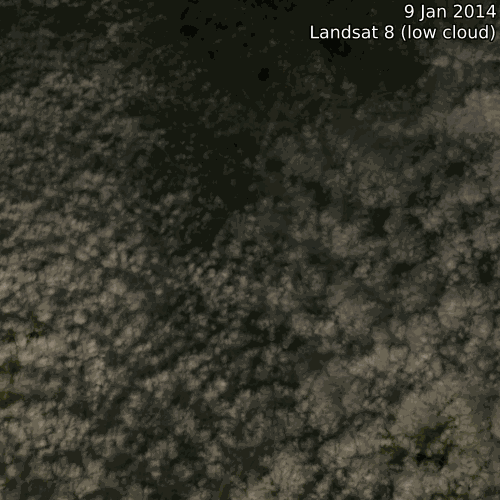

In [22]:
Image(filename=gif_out_file, embed=True)

Further processing is likely in order to make this animation smoother and more refined. But from this output, we can already clearly observe some of the dynamics of land cover changes over time, as well as the rise and fall of the water level in the reservoir, for instance.

In [23]:
## Be a good dask user - Clean up the cluster resources

In [24]:
client.close()

cluster.close()

In [ ]:
### End notebook